In [2]:
%matplotlib inline

import sys
sys.path.append("..")

In [89]:
pwd

'/om/user/vanessad/understanding_reasoning/original_library/systematic-generalization-sqoop_2objects/scripts/notebooks'

In [65]:
import os
import io
import json
import h5py
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import PIL
import torch
from functions_sqoop import generate_in_sample, evaluate_activations, read_output_files, LongTailSampler
from vr.models.shnmn import _shnmn_func
from analyze_models import data_name, load_data_, feats_to_image
from torch.autograd import Variable
import torch.nn.functional as F
from vr.utils import load_execution_engine, load_program_generator
from train_model import get_execution_engine
from vr.utils import load_vocab
from vr.data import ClevrDataset, ClevrDataLoader
from train_model import check_accuracy

# Data generation for in-sample test data

We generate a new dataset and respect the distribution used at training. Data path contains all the data folders for 2 and 5 objects per image.

In [5]:
root_path = './../../..'

In [ ]:
# 1st index : 2 or 5 objects per image
# 2nd index : lhs configurations

data_path = join(root_path, 'datasets', data_name[2][18])  
generate_in_sample(data_path, output_path=data_path)

# Load model and give a hand-crafted example

**X, R, Y**: are the idx for 1st object, relation and 2nd object  
**posx**: list of two values containing (x,y) coordinates for 1st object: given the dimensions of the object fixed at 10, it does not make sense to go out of the range [5, 59]  
**posy**: same as posx for the 2nd object, avoid overlap  
**path_vocab_dataset**: path to the vocabulary  
**path_model**: folder containing the results  
**model_file**: model name

In [6]:
path_ = join(root_path, 'datasets', data_name[2][1])
path_vocab_dataset = join(path_, 'vocab.json')
vocab_dataset = load_vocab(path_vocab_dataset)
path_model = join(root_path, 'systematic-generalization-sqoop_2objects/results/tree_models_2objs/residual/lhs1')
lst_slurm_file = [f_ for f_ in os.listdir(path_model) if f_.endswith('.pt.best')]
model_file = lst_slurm_file[0] 

**NOTE**  
If you want to retrieve questions, making new ones, all you have to do is using the vocab

In [7]:
question_words = ['A', 'above', 'D']

question_idx = [vocab_dataset['question_token_to_idx'][q_] for q_ in question_words]
print(question_idx)
question_token = [vocab_dataset['question_idx_to_token'][q_] for q_ in question_idx]

[7, 45, 10]


using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
torch.Size([3, 82112]) torch.Size([1, 64, 16, 16])
0


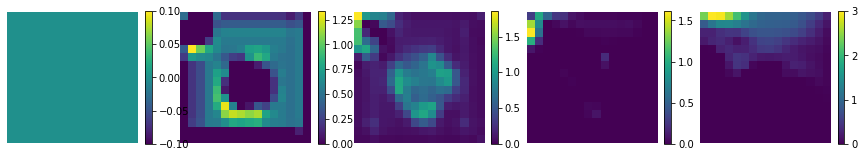

1


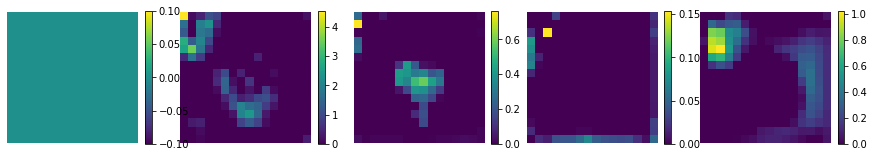

2


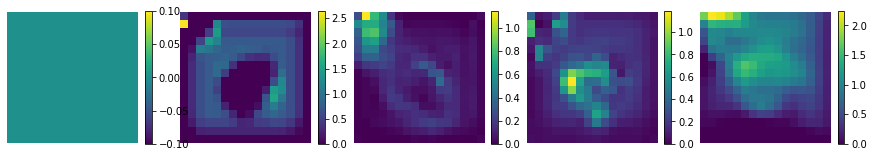

3


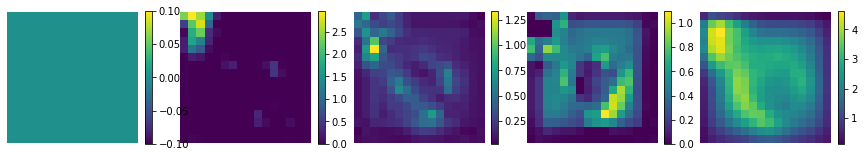

4


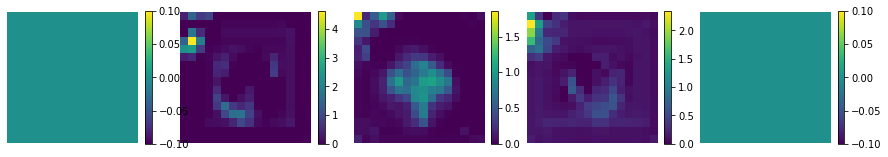

5


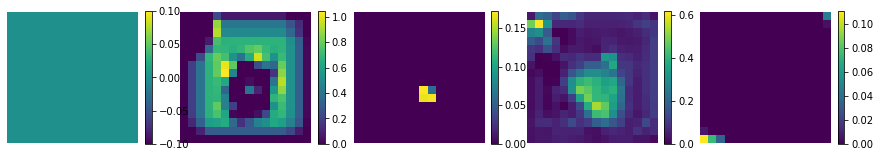

6


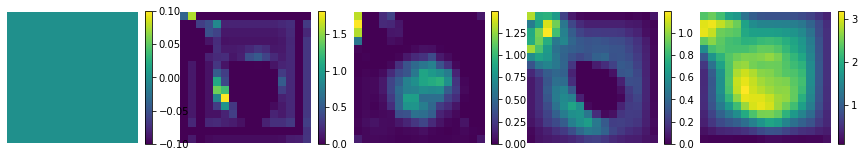

7


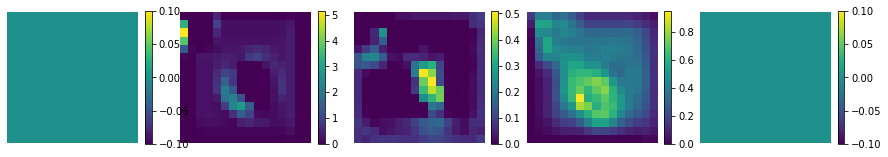

8


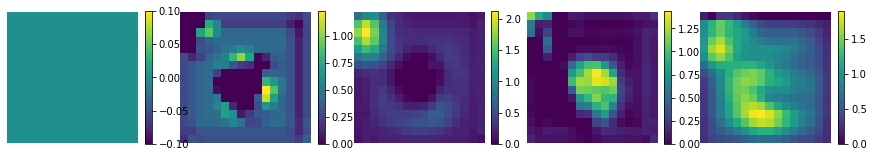

9


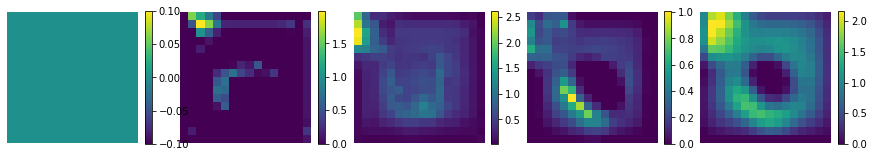

10


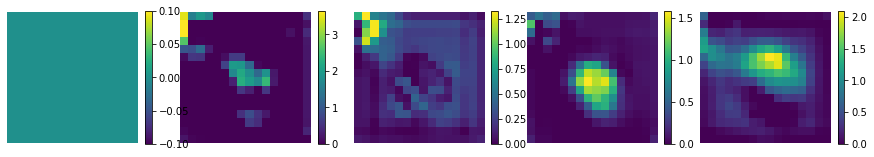

11


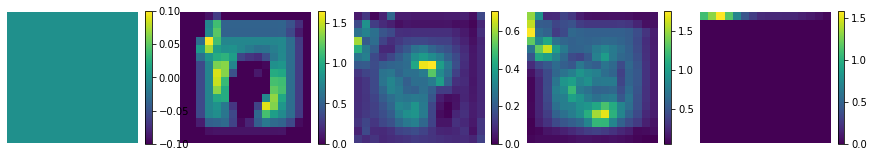

12


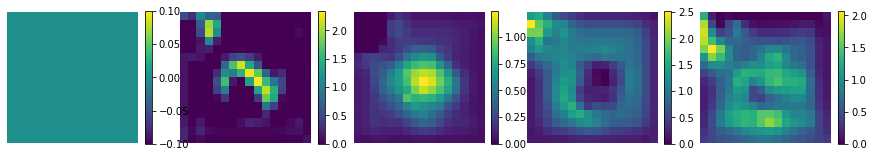

13


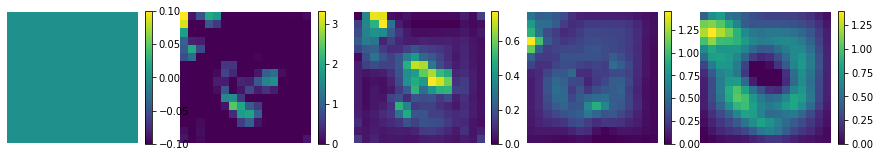

14


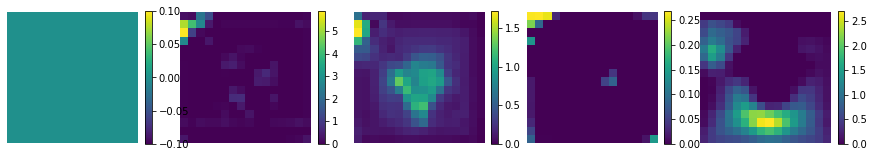

15


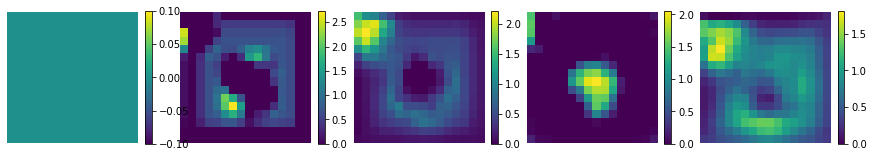

16


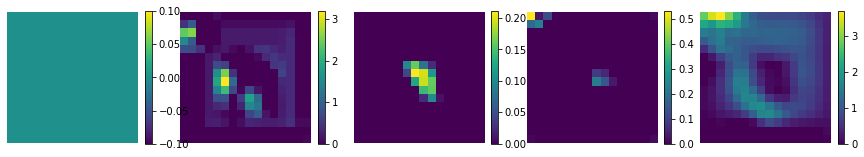

17


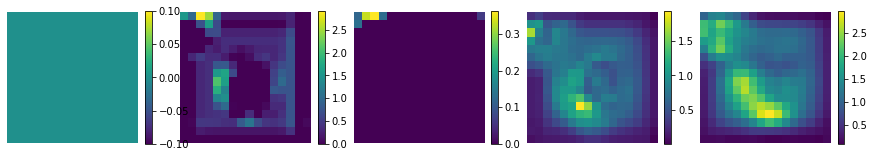

18


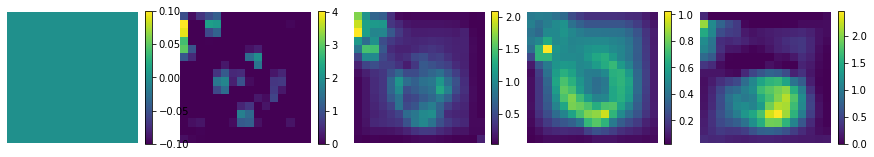

19


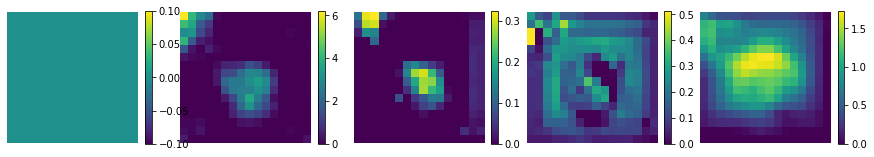

20


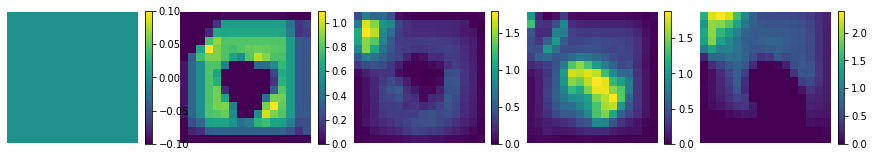

21


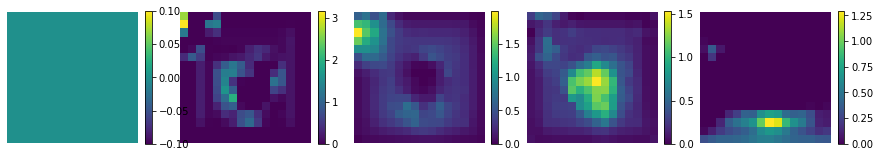

22


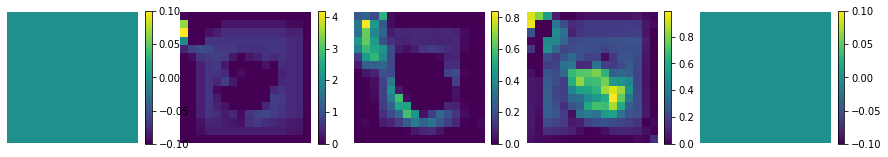

23


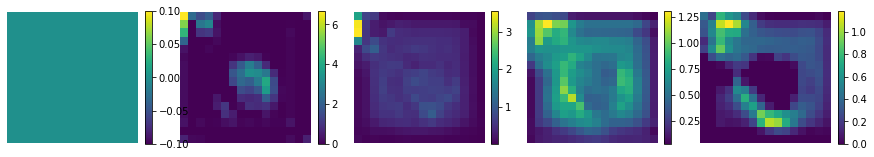

24


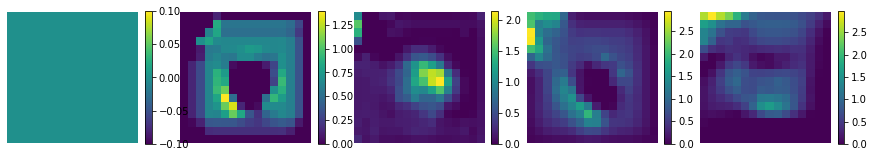

25


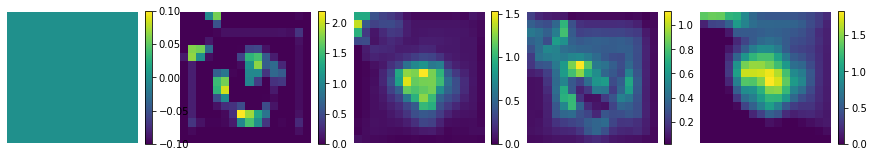

26


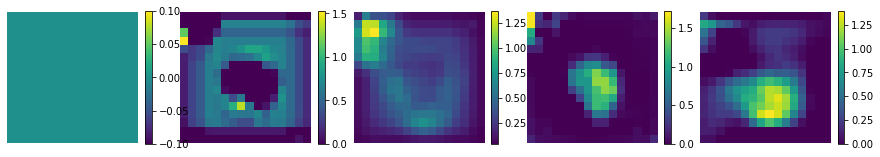

27


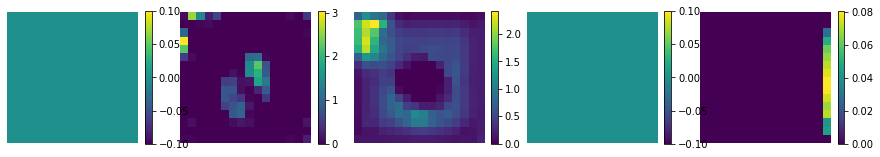

28


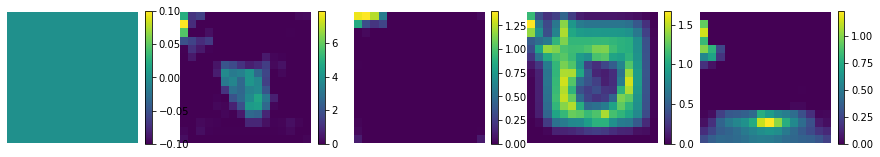

29


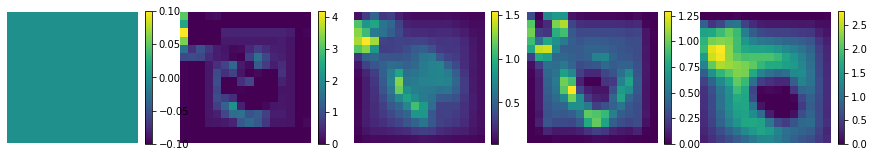

30


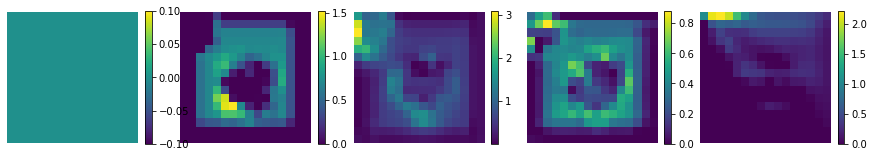

31


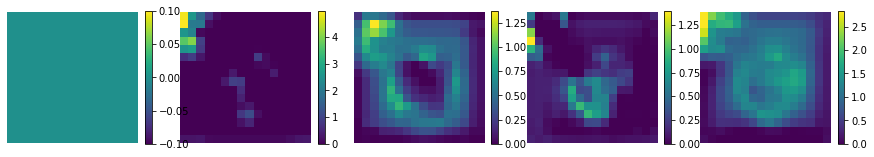

32


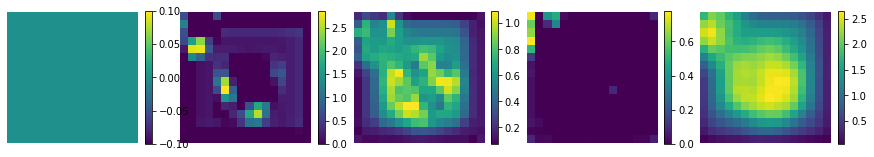

33


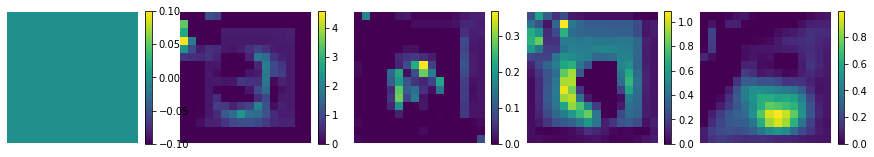

34


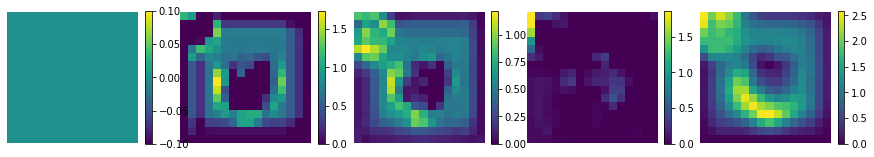

35


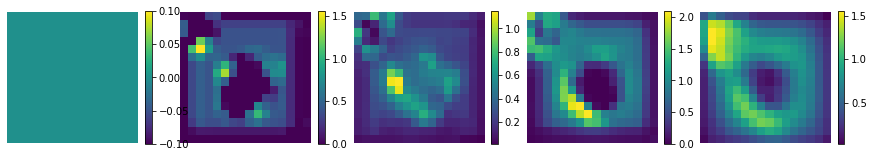

36


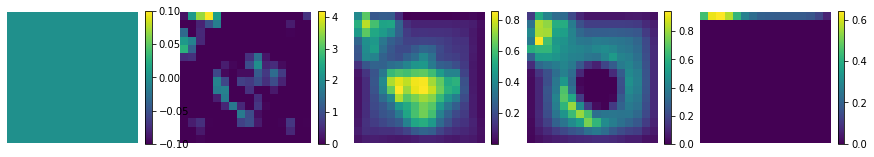

37


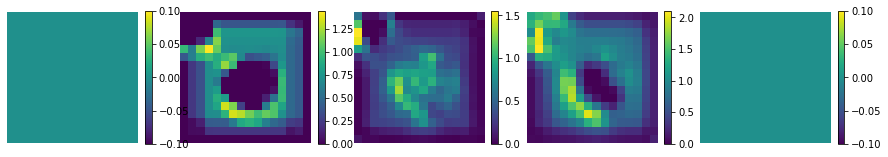

38


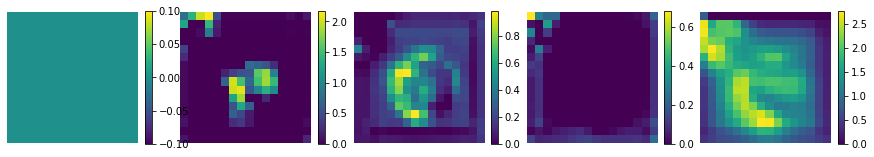

39


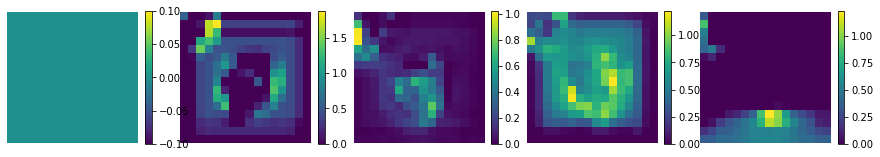

40


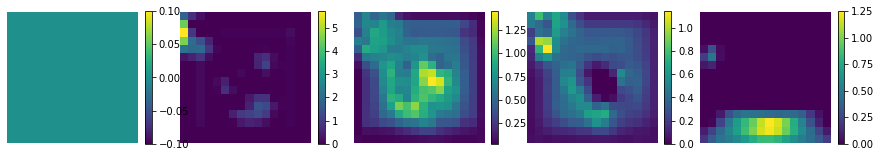

41


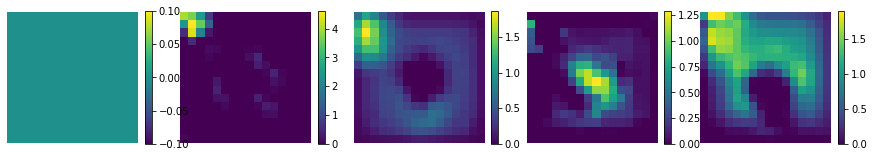

42


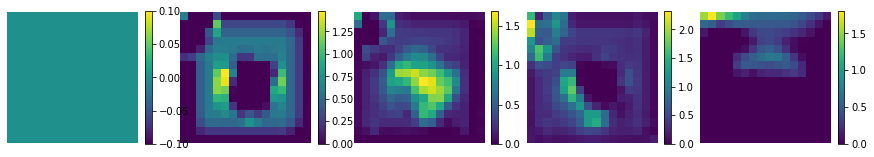

43


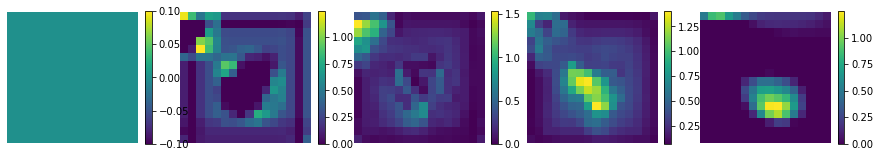

44


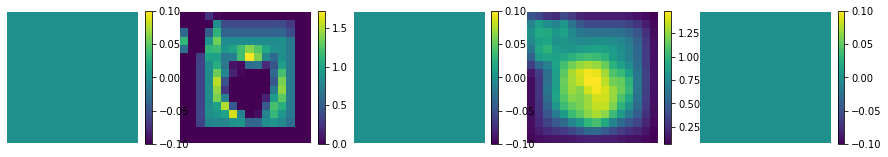

45


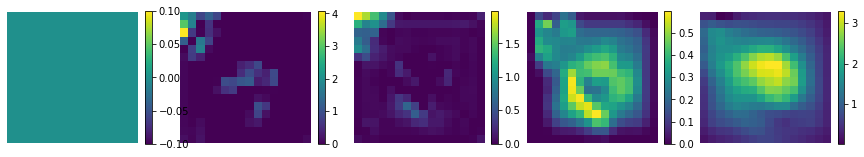

46


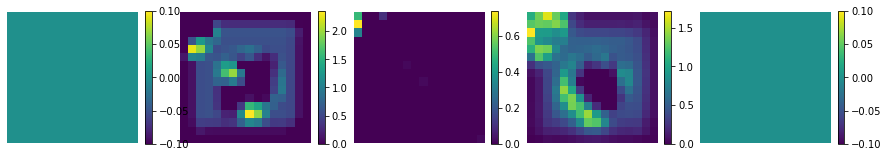

47


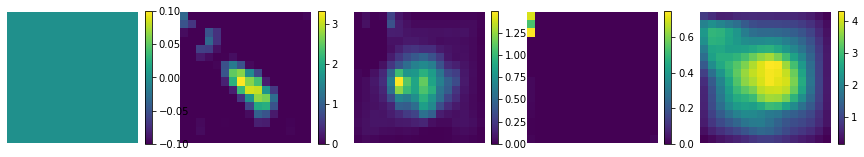

48


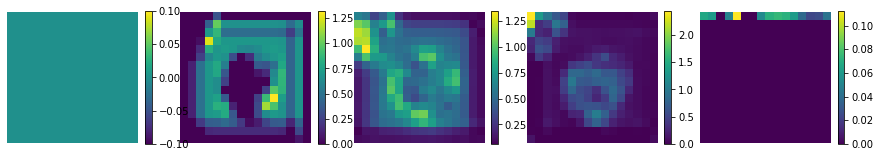

49


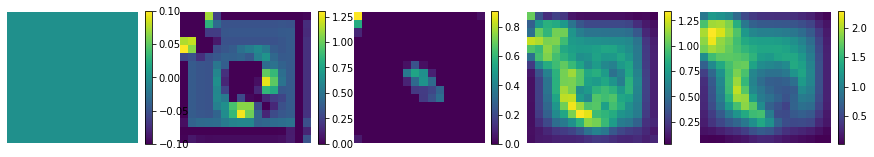

50


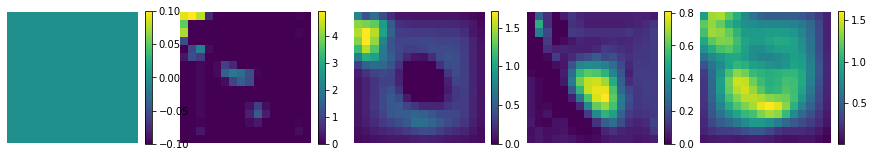

51


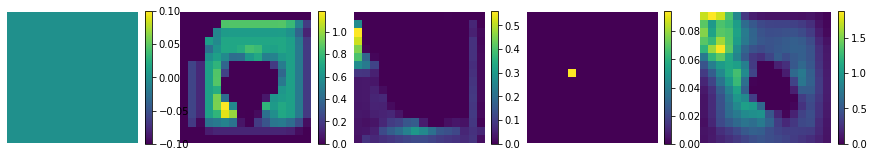

52


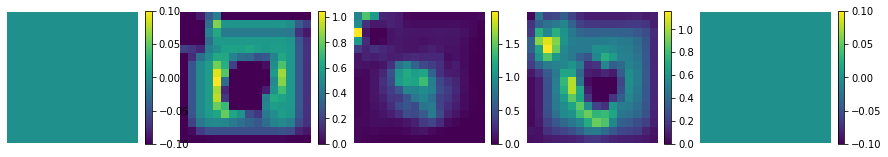

53


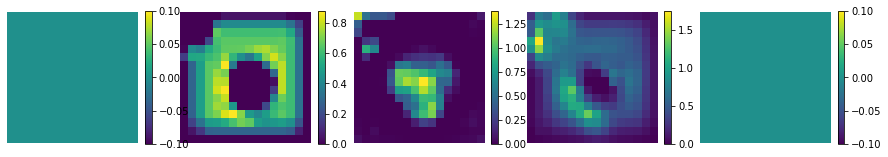

54


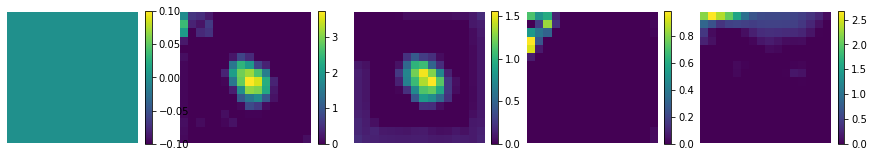

55


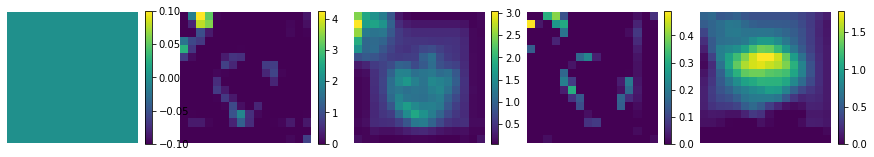

56


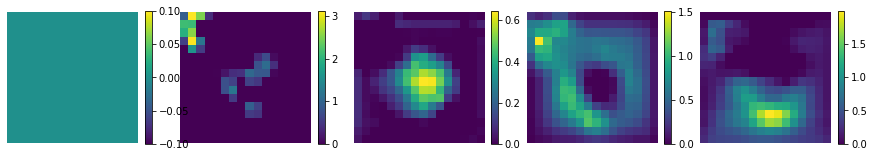

57


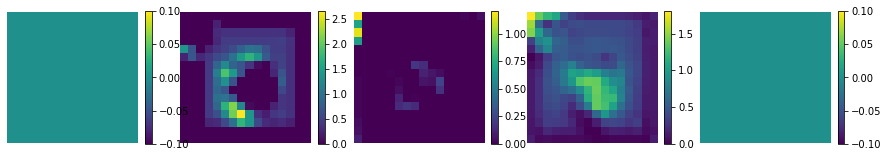

58


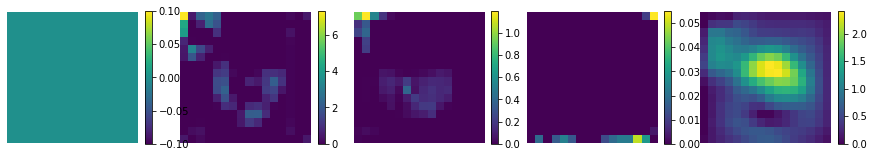

59


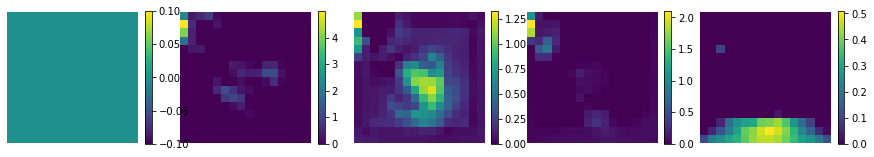

60


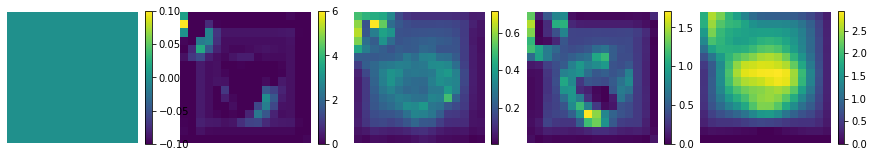

61


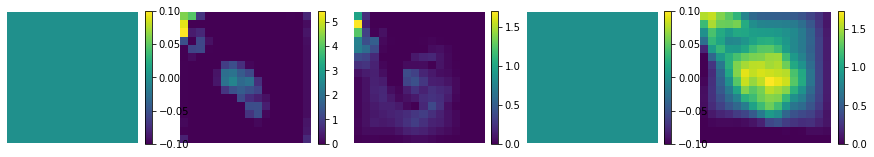

62


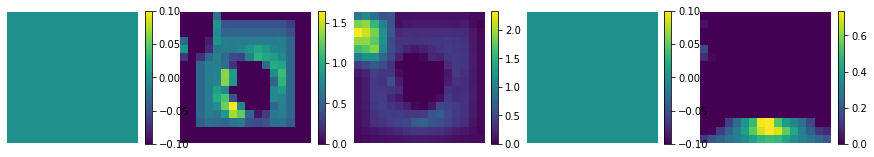

63


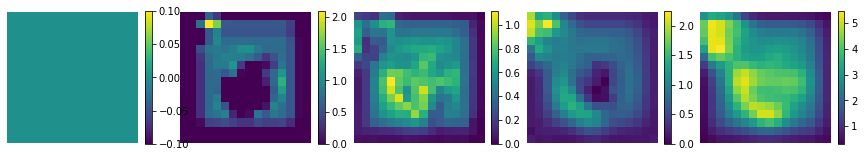

In [8]:
img_, _, pred = evaluate_activations(X=22, R=45, Y=31, pos_x=[5,5], pos_y=[35,35], 
                                     path_vocab_dataset=path_vocab_dataset,
                                     path_model=path_model,
                                     model_file=model_file)

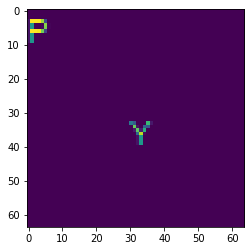

tensor([[1.0000e+00, 1.2864e-06]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [9]:
plt.imshow(img_[1])
plt.show()
pred

Each column here refers to a module (1) sentinel=0, (2) feature output from stem, (3) module X, (4) module Y, and (5) module (R). The number of rows if fixed at 64.

# Test values for original and flipped shortcut chain models

In [22]:
path_ch_sh = join(root_path, 'systematic-generalization-sqoop_2objects/results/chain_w_shortcuts_models_2objs/residual/lhs1')
output_in_sample = [join(path_ch_sh, f_) for f_ in os.listdir(path_ch_sh) if f_.startswith('output_in_sample')]
output_out_sample = [join(path_ch_sh, f_) for f_ in os.listdir(path_ch_sh) if (not f_.startswith('output_in_sample') and
                                                             f_.startswith('output'))]

In [23]:
read_output_files(slurm_id_lst=None, path_output=output_in_sample)

array([0.        , 0.00203252, 0.00016938, 0.        , 0.00186314])

In [24]:
test_out_original = read_output_files(slurm_id_lst=None, path_output=output_out_sample)
print(test_out_original)
print(np.mean(test_out_original), np.std(test_out_original))

[0.32401961 0.30686275 0.35375817 0.30669935 0.33366013]
0.325 0.01770234621859366


In [25]:
path_ch_flp_sh = join(root_path, 'systematic-generalization-sqoop_2objects/results/chain_w_shortcuts_flipped_models_2objs/residual/lhs1')
output_in_sample = [join(path_ch_flp_sh, f_) for f_ in os.listdir(path_ch_flp_sh) if f_.startswith('output_in_sample')]
output_out_sample = [join(path_ch_flp_sh, f_) for f_ in os.listdir(path_ch_flp_sh) if (not f_.startswith('output_in_sample') and
                                                                                       f_.startswith('output'))]

In [26]:
read_output_files(slurm_id_lst=None, path_output=output_in_sample)

array([0.00016938, 0.00101626, 0.        , 0.00067751, 0.00016938])

In [27]:
test_out_flipped = read_output_files(slurm_id_lst=None, path_output=output_out_sample)
print(test_out_flipped)
print(np.mean(test_out_flipped), np.std(test_out_flipped))

[0.23055556 0.28839869 0.35179739 0.28153595 0.27205882]
0.2848692810457516 0.039030827915744463


# Report precomputed activation maps 

Compute the activation maps for each example in the test_in_sample 

['9', 'below', 'Q']
['W', 'right_of', 'E']
['I', 'left_of', 'Y']
['R', 'above', '8']
['W', 'below', 'K']
['W', 'below', '4']
['W', 'left_of', 'D']
['I', 'above', 'J']
['W', 'right_of', 'K']


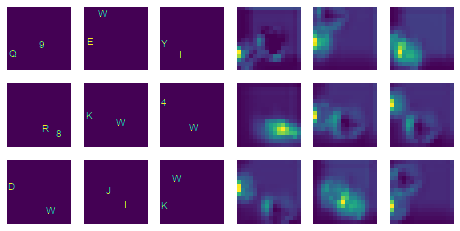

In [87]:
lhs = 18  # 1 or 18
model_type = 'tree'  #  tree, chain, chain_w_shortcuts, chain_w_shortcuts_flipped
module_type = 'residual'  # residual or find

data_path = join(root_path, 'datasets', data_name[2][lhs])
feats, quests, answrs = load_data_(data_path, file_str='test_in_sample')
path_model = join(root_path, 'systematic-generalization-sqoop_2objects/results',
                  '%s_models_2objs' % model_type,
                  module_type,
                  'lhs%i' %lhs)
slurm_id = 0  # one of the five experiments
module = 0  # 0=X, 1=Y, 2=R
dim_ = 10  # one of the 64 feature maps

lst_slurm_files = [f_.split('.')[0] for f_ in os.listdir(path_model) if f_.endswith('.pt.best')]
max_activations_idx = np.load(join(path_model, '%s_idx_images.npy' % lst_slurm_files[slurm_id]))
activation_maps = np.load(join(path_model, '%s_activation_maps.npy' % lst_slurm_files[slurm_id]))
_, module_dim, top_n, map_dim, _ = activation_maps.shape

fig, ax = plt.subplots(figsize=(8,4), ncols=top_n//3 * 2, nrows=top_n//3)
for i_, (top_map, id_image) in enumerate(zip(activation_maps[module, dim_, :, :, :],
                                             max_activations_idx[:, module, dim_])):
    print([vocab['question_idx_to_token'][q_] for q_ in quests[id_image]])
    img = feats_to_image(feats[id_image])
    ax[i_ // 3, i_ % 3].imshow(img[1])
    ax[i_ // 3, 3 + i_ % 3].imshow(top_map)
    ax[i_ // 3, i_ % 3].axis('off')
    ax[i_ // 3, 3 + i_ % 3].axis('off')


plt.show()